### 公立中学校のクラス編成問題

-   【要件1】学年の全生徒をそれぞれ1つのクラスに割り当てる。
-   【要件2】各クラスの人数は39人以上、40人以下とする。　　318人の生徒、8つのクラス。
-   【要件3】各クラスの男子生徒、女子生徒の人数は20人以下とする。　男子生徒158人、女子生徒160人。
-   【要件4】各クラスの学力の平均点は学年平均の$\pm10$点とする。　500点満点で、学年平均303.6点。
-   【要件5】各クラスにリーダー気質の生徒を2人以上割り当てる。　　学年にリーダー気質は17人。
-   【要件6】特別な支援が必要な生徒は各クラスに1人以下とする。　　学年に特別な支援が必要な生徒は4人。
-   【要件7】特定ペアの生徒は同一クラスに割り当てない　　　　　　 学年に特定ペアは3組みいる。

1.データの中身の確認

In [52]:
import pandas as pd

s_df = pd.read_csv("students.csv")
print(f"students.csvの要素数：{len(s_df)}")
s_df.head()

students.csvの要素数：318


,student_id,gender,leader_flag,support_flag,score
0,1,0,0,0,335
1,2,1,0,0,379
2,3,0,0,0,350
3,4,0,0,0,301
4,5,1,0,0,317


次に、カラムに登録されているデータを確認してみる。

In [53]:
s_df["student_id"]

0        1
1        2
2        3
3        4
4        5
      ... 
313    314
314    315
315    316
316    317
317    318
Name: student_id, Length: 318, dtype: int64

In [54]:
print(s_df["student_id"].max()) # 学籍番号の最大値と最小値の確認
print(s_df["student_id"].min())

318
1


In [55]:
set(range(1, 319)) == set(s_df["student_id"].tolist()) # 1～318まで隙間なく番号で埋められているか確認
# range(1, 319)で1～318までの整数を作り、set()でそれらを集合にしている。
# 抜けや重複があればFalse が返る

True

genderの中身を確認してみる。value_counts()で、カラム内の各要素（0 or 1）の数をカウントする。

In [56]:
s_df["gender"].value_counts()

gender
0    160
1    158
Name: count, dtype: int64

次に、scoreを確認する。describe()関数で、カラム内の基本的な統計要約を出力する。

In [57]:
s_df["score"].describe()

count    318.000000
mean     303.644654
std       65.179995
min       88.000000
25%      261.000000
50%      310.000000
75%      350.000000
max      485.000000
Name: score, dtype: float64

学力データをヒストグラムで確認してみる。

<Axes: >

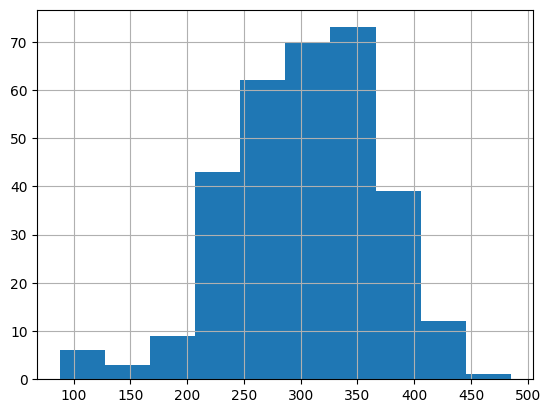

In [58]:
s_df["score"].hist(bins=10)

最後に、leader_flagとsupport_flagの確認をする。

In [59]:
print(s_df["leader_flag"].value_counts())
print(s_df["support_flag"].value_counts())

leader_flag
0    301
1     17
Name: count, dtype: int64
support_flag
0    314
1      4
Name: count, dtype: int64


### 以上で、生徒データの確認は完了。

次に、特定ペアのデータを確認する。三組（0，1，2）の特定ペアが存在している。

In [60]:
s_pair_df = pd.read_csv("student_pairs.csv")
print(f"students_pairs.csvの要素数：{len(s_pair_df)}")
s_pair_df.head()

students_pairs.csvの要素数：3


,student_id1,student_id2
0,118,189
1,72,50
2,314,233


### 以上で、データの確認は完了。続いて数理モデリングと実装に入る。

Pulpを取り込んで、数理モデルのインスタンスを生成。
今回は目的関数は定義しないが、次章で最大化問題を使うので、ここではLpMaximizeを使用する。

In [61]:
import pulp

prob = pulp.LpProblem("ClassAssignmentProblem", pulp.LpMaximize)  # 数理モデルのインスタンスを生成

ここから、冒頭の7つの要件を数理モデリングしていく。

-   【要件1】学年の全生徒をそれぞれ1つのクラスに割り当てる。
-   【要件2】各クラスの人数は39人以上、40人以下とする。　　318人の生徒、8つのクラス。
-   【要件3】各クラスの男子生徒、女子生徒の人数は20人以下とする。　男子生徒158人、女子生徒160人。
-   【要件4】各クラスの学力の平均点は学年平均の$\pm10$点とする。　500点満点で、学年平均303.6点。
-   【要件5】各クラスにリーダー気質の生徒を2人以上割り当てる。　　学年にリーダー気質は17人。
-   【要件6】特別な支援が必要な生徒は各クラスに1人以下とする。　　学年に特別な支援が必要な生徒は4人。
-   【要件7】特定ペアの生徒は同一クラスに割り当てない　　　　　　 学年に特定ペアは3組みいる。

### 【要件1】各生徒は1つのクラスに割り当てる
$$\sum_{c \in C} x_{s,c} = 1 \; (x \in {0, 1})$$

生徒 s が、クラスc に割り当てられると、1になる。ある生徒sは、8クラス中1クラスのみ1になるので、8クラス中1クラスだけ1，他7クラス分は0となる。それら８つを足し合わせて1になる。

では、生徒のリストSとクラスのリストCを作る。

In [62]:
S = s_df["student_id"].tolist()               # 生徒のリスト（データフレームから学籍番号をリストで取得。）
C = ["A", "B", "C", "D", "E", "F", "G", "H"]  # 8クラス分のリスト（自分で作成）

次に、生徒をどのクラスに割り当てるかを実装する。

生徒とクラスの考えられる全ペアのリストと、変数を定義する。

In [63]:
SC = [(s, c) for s in S for c in C]  # 生徒 s とクラス c の全組み合わせのリストを作成。

x = pulp.LpVariable.dicts("x", SC, cat="Binary")
                            # 第一引数：変数名
                            # 第二引数：まとめて作る変数の添え字リスト（学籍番号, クラス名）
                            # 第三引数：変数のタイプ（Binaryなので、０か１かをとる）

先ほどの式、$\sum_{c \in C} x_{s,c} = 1$ をpulpのipSum関数で表すと、下記のようになる。

各生徒について、８クラス分所属するかの変数 x （０or１のバイナリ）を足し合わせたものが１．（＝各生徒は１クラスにのみ所属する。）

In [64]:
for s in S:
    prob += pulp.lpSum([x[s, c] for c in C]) == 1

### 【要件2】各クラスの人数は39人以上、40人以下とする。　　318人の生徒、8つのクラス。
各クラスにおいて、全生徒の変数を足し合わせて、39以上４０以下になるように。
$$\sum_{s \in S} x_{s,c} \geq 39$$
$$\sum_{s \in S} x_{s,c} \leq 40$$

In [65]:
# (2)各クラスの生徒数は３９人以上４０人以下とする。
for c in C:
    prob += pulp.lpSum([x[s, c] for s in S]) >= 39
    prob += pulp.lpSum([x[s, c] for s in S]) <= 40

### 【要件３】各クラスの男子生徒、女子生徒の数は２０人以下とする。
男女別に制約条件を定義する。
$$\sum_{s \in S_{male}} x_{s,c} \leq 20$$
$$\sum_{s \in S_{female}} x_{s,c} \leq 20$$
事前に、男子生徒と女子生徒のリストを定義しておくと、制約条件の定義がスムーズにできる。

In [66]:
# まず男子生徒S_male、女子生徒S_femaleのリストを作る

# 男子生徒のリスト(gender ==1)
S_male = [row.student_id for row in s_df.itertuples() if row.gender == 1]
# 女子生徒のリスト
S_female = [row.student_id for row in s_df.itertuples() if row.gender == 0]
# 要素数の確認
print(len(S_male + S_female))

# リストを使って制約条件を定義
for c in C:
    prob += pulp.lpSum([x[s, c] for s in S_male]) <= 20
    prob += pulp.lpSum([x[s, c] for s in S_female]) <= 20

318


### 【要件４】各クラスの学力の平均点は、学年平均の$\pm10$点とする。　500点満点で、学年平均303.6点。
- 定数（各生徒学力）：$score_{s}$
- 定数（学年平均点）：$score\_mean$
- クラス平均点：$$\frac{\sum_{s \in S} score_{s} \cdot x_{s,c}}{\sum_{s \in S}  x_{s,c}}$$
したがって、制約条件は、$$score\_mean - 10 \leq \frac{\sum_{s \in S} score_{s} \cdot x_{s,c}}{\sum_{s \in S}  x_{s,c}}$$
および、$$\frac{\sum_{s \in S} score_{s} \cdot x_{s,c}}{\sum_{s \in S}  x_{s,c}}　\leq score\_mean + 10$$

ここで、クラス平均点の分子・分母ともに変数が含まれているので、非線形の式になっている。
解くのが大変なので、通分して、線形の式に書き換えるのが定石らしい。

よって、最終的な制約条件は$$(score\_mean - 10) \cdot \sum_{s \in S}  x_{s,c} \leq \sum_{s \in S} score_{s} \cdot x_{s,c}$$
および、$$\sum_{s \in S} score_{s} \cdot x_{s,c}　\leq (score\_mean + 10) \cdot \sum_{s \in S}  x_{s,c}$$

In [67]:
# 各生徒の学力（学籍番号：点数）
score = {row.student_id:row.score for row in s_df.itertuples()}

# 平均点の算出
score_mean = s_df["score"].mean()
print(score_mean)

# 制約条件（各クラスの平均点は、学年平均の±１０点以下）
for c in C:
    prob += (score_mean - 10)*pulp.lpSum([x[s, c] for s in S]) <= pulp.lpSum([score[s] * x[s, c] for s in S])
    prob += pulp.lpSum([score[s] * x[s, c] for s in S]) <= (score_mean + 10) * pulp.lpSum([x[s, c] for s in S])

303.6446540880503


### 【要件５】各クラスにリーダー気質の生徒を２人以上割り当てる。
各クラスにおいて、全生徒中２人以上のリーダー気質な生徒を設定。
$$\sum_{s \in S_{leader}}  x_{s,c} \geq 2 \; (c \in C)$$

In [68]:
# リーダー気質な生徒のリスト
S_leader = [row.student_id for row in s_df.itertuples() if row.leader_flag == 1]
print(len(S_leader))

# 制約条件（各クラスにリーダー気質な生徒を２人以上割り当てる）
for c in C:
    prob += pulp.lpSum([x[s, c] for s in S_leader]) >= 2

17


### 【要件６】特別な支援が必要な生徒は、各クラスに1人以下とする。
各クラスにおいて、特別な支援が必要な生徒は１人までとする。
$$\sum_{s \in S_{support}}  x_{s,c} \leq 1 \; (c \in C)$$
実装は、リーダー気質の場合と同様。

In [69]:
# 特別の支援が必要な生徒のリスト
S_support = [row.student_id for row in s_df.itertuples() if row.support_flag == 1]
print(len(S_support))

# 制約条件（各クラスにリーダー気質な生徒を２人以上割り当てる）
for c in C:
    prob += pulp.lpSum([x[s, c] for s in S_support]) <= 1

4


### 【要件７】特定ペアの生徒同士は同一クラスに割り当てない
- 生徒の特定ペアリスト：$$SS$$
- 特定ペア（s1, s2）の生徒は、同一クラスに割り当てない。

つまり、各クラスにおいて、二人を足して１以下である必要がある。 $$x_{s1,c} + x_{s2,c} \leq 1 \; (c \in C, (s1, s2) \in SS)$$

In [70]:
# 特定ペアのリスト
SS = [(row.student_id1, row.student_id2) for row in s_pair_df.itertuples()]
print(SS)

[(118, 189), (72, 50), (314, 233)]


In [71]:
# 制約条件の定義
for s1, s2 in SS:
    for c in C:
        prob += x[s1, c] + x[s2, c] <= 1

In [72]:
prob

ClassAssignmentProblem:
MAXIMIZE
None
SUBJECT TO
_C1: x_(1,_'A') + x_(1,_'B') + x_(1,_'C') + x_(1,_'D') + x_(1,_'E')
 + x_(1,_'F') + x_(1,_'G') + x_(1,_'H') = 1

_C2: x_(2,_'A') + x_(2,_'B') + x_(2,_'C') + x_(2,_'D') + x_(2,_'E')
 + x_(2,_'F') + x_(2,_'G') + x_(2,_'H') = 1

_C3: x_(3,_'A') + x_(3,_'B') + x_(3,_'C') + x_(3,_'D') + x_(3,_'E')
 + x_(3,_'F') + x_(3,_'G') + x_(3,_'H') = 1

_C4: x_(4,_'A') + x_(4,_'B') + x_(4,_'C') + x_(4,_'D') + x_(4,_'E')
 + x_(4,_'F') + x_(4,_'G') + x_(4,_'H') = 1

_C5: x_(5,_'A') + x_(5,_'B') + x_(5,_'C') + x_(5,_'D') + x_(5,_'E')
 + x_(5,_'F') + x_(5,_'G') + x_(5,_'H') = 1

_C6: x_(6,_'A') + x_(6,_'B') + x_(6,_'C') + x_(6,_'D') + x_(6,_'E')
 + x_(6,_'F') + x_(6,_'G') + x_(6,_'H') = 1

_C7: x_(7,_'A') + x_(7,_'B') + x_(7,_'C') + x_(7,_'D') + x_(7,_'E')
 + x_(7,_'F') + x_(7,_'G') + x_(7,_'H') = 1

_C8: x_(8,_'A') + x_(8,_'B') + x_(8,_'C') + x_(8,_'D') + x_(8,_'E')
 + x_(8,_'F') + x_(8,_'G') + x_(8,_'H') = 1

_C9: x_(9,_'A') + x_(9,_'B') + x_(9,_'C') + x_(

### 条件が出そろったので、求解する

In [73]:
status = prob.solve()
print(status)
print(pulp.LpStatus[status])

1
Optimal


### 最適化の結果を表示する

In [74]:
# クラス分けの辞書配列を作成する
C2Ss = {}
for c in C:
    C2Ss[c] = [s for s in S if x[s, c].value() == 1]  # そのクラス C （値）に割り当てられた生徒の学籍番号（キー）を、辞書に追加していく。
                                                      # そのクラスの生徒が出そろったら、次のクラスの処理。

for c, Ss in C2Ss.items():
    print("Class : ", c)
    print("Num. of student", len(Ss))
    print("Student", Ss)
    print()

Class :  A
Num. of student 40
Student [2, 9, 19, 39, 42, 63, 65, 71, 79, 83, 85, 88, 99, 101, 109, 111, 123, 126, 136, 138, 145, 148, 165, 168, 173, 177, 179, 180, 193, 199, 206, 224, 233, 240, 246, 264, 267, 291, 292, 298]

Class :  B
Num. of student 39
Student [1, 11, 15, 43, 48, 50, 70, 82, 89, 91, 102, 104, 113, 114, 120, 121, 124, 127, 134, 149, 159, 167, 170, 176, 190, 203, 213, 220, 222, 231, 238, 245, 270, 275, 276, 283, 287, 290, 317]

Class :  C
Num. of student 40
Student [3, 14, 23, 25, 27, 31, 33, 41, 49, 53, 54, 58, 73, 93, 97, 98, 107, 122, 152, 156, 160, 171, 187, 210, 211, 217, 219, 227, 236, 242, 254, 258, 260, 268, 273, 274, 277, 278, 301, 318]

Class :  D
Num. of student 40
Student [10, 13, 16, 20, 36, 37, 51, 56, 59, 61, 67, 68, 75, 84, 92, 108, 128, 139, 140, 142, 146, 158, 161, 175, 183, 192, 198, 200, 221, 225, 235, 241, 252, 255, 256, 257, 266, 284, 293, 316]

Class :  E
Num. of student 40
Student [4, 5, 21, 22, 24, 38, 69, 72, 78, 87, 96, 105, 106, 115, 129, 13

In [75]:
print(C2Ss)

{'A': [2, 9, 19, 39, 42, 63, 65, 71, 79, 83, 85, 88, 99, 101, 109, 111, 123, 126, 136, 138, 145, 148, 165, 168, 173, 177, 179, 180, 193, 199, 206, 224, 233, 240, 246, 264, 267, 291, 292, 298], 'B': [1, 11, 15, 43, 48, 50, 70, 82, 89, 91, 102, 104, 113, 114, 120, 121, 124, 127, 134, 149, 159, 167, 170, 176, 190, 203, 213, 220, 222, 231, 238, 245, 270, 275, 276, 283, 287, 290, 317], 'C': [3, 14, 23, 25, 27, 31, 33, 41, 49, 53, 54, 58, 73, 93, 97, 98, 107, 122, 152, 156, 160, 171, 187, 210, 211, 217, 219, 227, 236, 242, 254, 258, 260, 268, 273, 274, 277, 278, 301, 318], 'D': [10, 13, 16, 20, 36, 37, 51, 56, 59, 61, 67, 68, 75, 84, 92, 108, 128, 139, 140, 142, 146, 158, 161, 175, 183, 192, 198, 200, 221, 225, 235, 241, 252, 255, 256, 257, 266, 284, 293, 316], 'E': [4, 5, 21, 22, 24, 38, 69, 72, 78, 87, 96, 105, 106, 115, 129, 132, 141, 143, 150, 154, 164, 166, 184, 189, 195, 196, 197, 243, 244, 247, 249, 250, 269, 271, 288, 300, 305, 309, 310, 315], 'F': [12, 17, 40, 45, 46, 74, 76, 80, 95

## 数理モデルの検証作業
## １.数理モデルが要件を満たしているか、確認していく。

### 【要件１】生徒は１つのクラスに割り当てられる

複数のクラスに割り当てられている生徒や、どのクラスにも割り当てられていない生徒がいないか、検証する。

In [76]:
# 各生徒ごとに、割り当てられたクラスを取得
for s in S:
    # その生徒が割り当てられたクラスを取得
    assigned_class = [c for c in C if x[s,c].value() == 1]
    # １つのクラスに割り当てられているか確認
    if len(assigned_class) != 1:
        print("error", s, assigned_class)

何も出力されなければ、問題なし。

続いて、各生徒がどのクラスに割り当てられたのかを、生徒データに結合しておく。

In [77]:
# 検証用データフレームの用意
result_df = s_df.copy() # 入力データは変更しないように、コピーして使う。

# 各生徒の振り分けを辞書に格納
S2C = {s:c for s in S for c in C if x[s,c].value() == 1}

In [78]:
print(S2C)

{1: 'B', 2: 'A', 3: 'C', 4: 'E', 5: 'E', 6: 'H', 7: 'G', 8: 'H', 9: 'A', 10: 'D', 11: 'B', 12: 'F', 13: 'D', 14: 'C', 15: 'B', 16: 'D', 17: 'F', 18: 'G', 19: 'A', 20: 'D', 21: 'E', 22: 'E', 23: 'C', 24: 'E', 25: 'C', 26: 'H', 27: 'C', 28: 'G', 29: 'H', 30: 'H', 31: 'C', 32: 'G', 33: 'C', 34: 'H', 35: 'G', 36: 'D', 37: 'D', 38: 'E', 39: 'A', 40: 'F', 41: 'C', 42: 'A', 43: 'B', 44: 'G', 45: 'F', 46: 'F', 47: 'H', 48: 'B', 49: 'C', 50: 'B', 51: 'D', 52: 'G', 53: 'C', 54: 'C', 55: 'G', 56: 'D', 57: 'G', 58: 'C', 59: 'D', 60: 'G', 61: 'D', 62: 'H', 63: 'A', 64: 'G', 65: 'A', 66: 'G', 67: 'D', 68: 'D', 69: 'E', 70: 'B', 71: 'A', 72: 'E', 73: 'C', 74: 'F', 75: 'D', 76: 'F', 77: 'H', 78: 'E', 79: 'A', 80: 'F', 81: 'G', 82: 'B', 83: 'A', 84: 'D', 85: 'A', 86: 'H', 87: 'E', 88: 'A', 89: 'B', 90: 'H', 91: 'B', 92: 'D', 93: 'C', 94: 'H', 95: 'F', 96: 'E', 97: 'C', 98: 'C', 99: 'A', 100: 'F', 101: 'A', 102: 'B', 103: 'F', 104: 'B', 105: 'E', 106: 'E', 107: 'C', 108: 'D', 109: 'A', 110: 'F', 111: 'A

In [79]:
result_df["assigned_class"] = result_df["student_id"].map(S2C)
result_df.head()

,student_id,gender,leader_flag,support_flag,score,assigned_class
0,1,0,0,0,335,B
1,2,1,0,0,379,A
2,3,0,0,0,350,C
3,4,0,0,0,301,E
4,5,1,0,0,317,E


### 【要件２】各クラスの人数は３９人以上４０人以下とする

各クラスに割り当てられた人数を確認する。

同じ asigned_class に属する行をグループ化。

そのグループのstudent_idをカウントする。

In [80]:
result_df.groupby("assigned_class")["student_id"].count()

assigned_class
A    40
B    39
C    40
D    40
E    40
F    40
G    40
H    39
Name: student_id, dtype: int64

### 【要件３】各クラスの男子生徒、女子生徒の数は２０人以下とする。

カウントのやり方は、先ほどと同様

In [81]:
result_df.groupby(["assigned_class", "gender"])["student_id"].count()

assigned_class  gender
A               0         20
                1         20
B               0         20
                1         19
C               0         20
                1         20
D               0         20
                1         20
E               0         20
                1         20
F               0         20
                1         20
G               0         20
                1         20
H               0         20
                1         19
Name: student_id, dtype: int64

### 【要件４】各クラスの学力の平均点は、学年平均の$\pm10$点とする。　500点満点で、学年平均303.6点。

なので、293.6～313.6の範囲内ならOK

In [82]:
result_df.groupby("assigned_class")["score"].mean()

assigned_class
A    306.875000
B    293.717949
C    312.125000
D    309.850000
E    294.550000
F    299.525000
G    313.200000
H    298.948718
Name: score, dtype: float64

### 【要件５】各クラスにリーダー気質の生徒を２人以上割り当てる。

クラスごとにグループ化して、それぞれのクラス内でleader_flagを合計する。

In [83]:
result_df.groupby("assigned_class")["leader_flag"].sum()

assigned_class
A    3
B    2
C    2
D    2
E    2
F    2
G    2
H    2
Name: leader_flag, dtype: int64

各クラス２人以上、また合計で１７人になっているので、問題なし。

### 【要件６】特別な支援が必要な生徒は、各クラスに1人以下とする。

In [85]:
result_df.groupby(["assigned_class"])["support_flag"].sum()

assigned_class
A    0
B    0
C    1
D    0
E    1
F    0
G    1
H    1
Name: support_flag, dtype: int64

各クラスに１人以下、かつ全体で４人なので、問題なし。

### 【要件７】特定ペアの生徒同士は同一クラスに割り当てない

特定ペアのリスト$SS$から、インデックスとそのペアを取り出して、どのクラスに割り振られたかを出力する。

In [87]:
for i, (s1,s2) in enumerate(SS):
    print("Case : ", i)
    c1 = S2C[s1]
    c2 = S2C[s2]
    print(f"s1 : {s1}---{c1}")
    print(f"s2 : {s2}---{c2}")
    print("")

Case :  0
s1 : 118---G
s2 : 189---E

Case :  1
s1 : 72---E
s2 : 50---B

Case :  2
s1 : 314---H
s2 : 233---A



ここまでで、設定した要件が満たされていることは確認できた。次に、詳細を確認して、改善できる部分があるか確認する。
### 設定した課題の見直しと、課題の洗い出し

【要件４】では、各クラスの学力平均を調整したが、その分布まではわからない。

各クラスの平均点は似ていても、その分布は異なっている可能性がある。

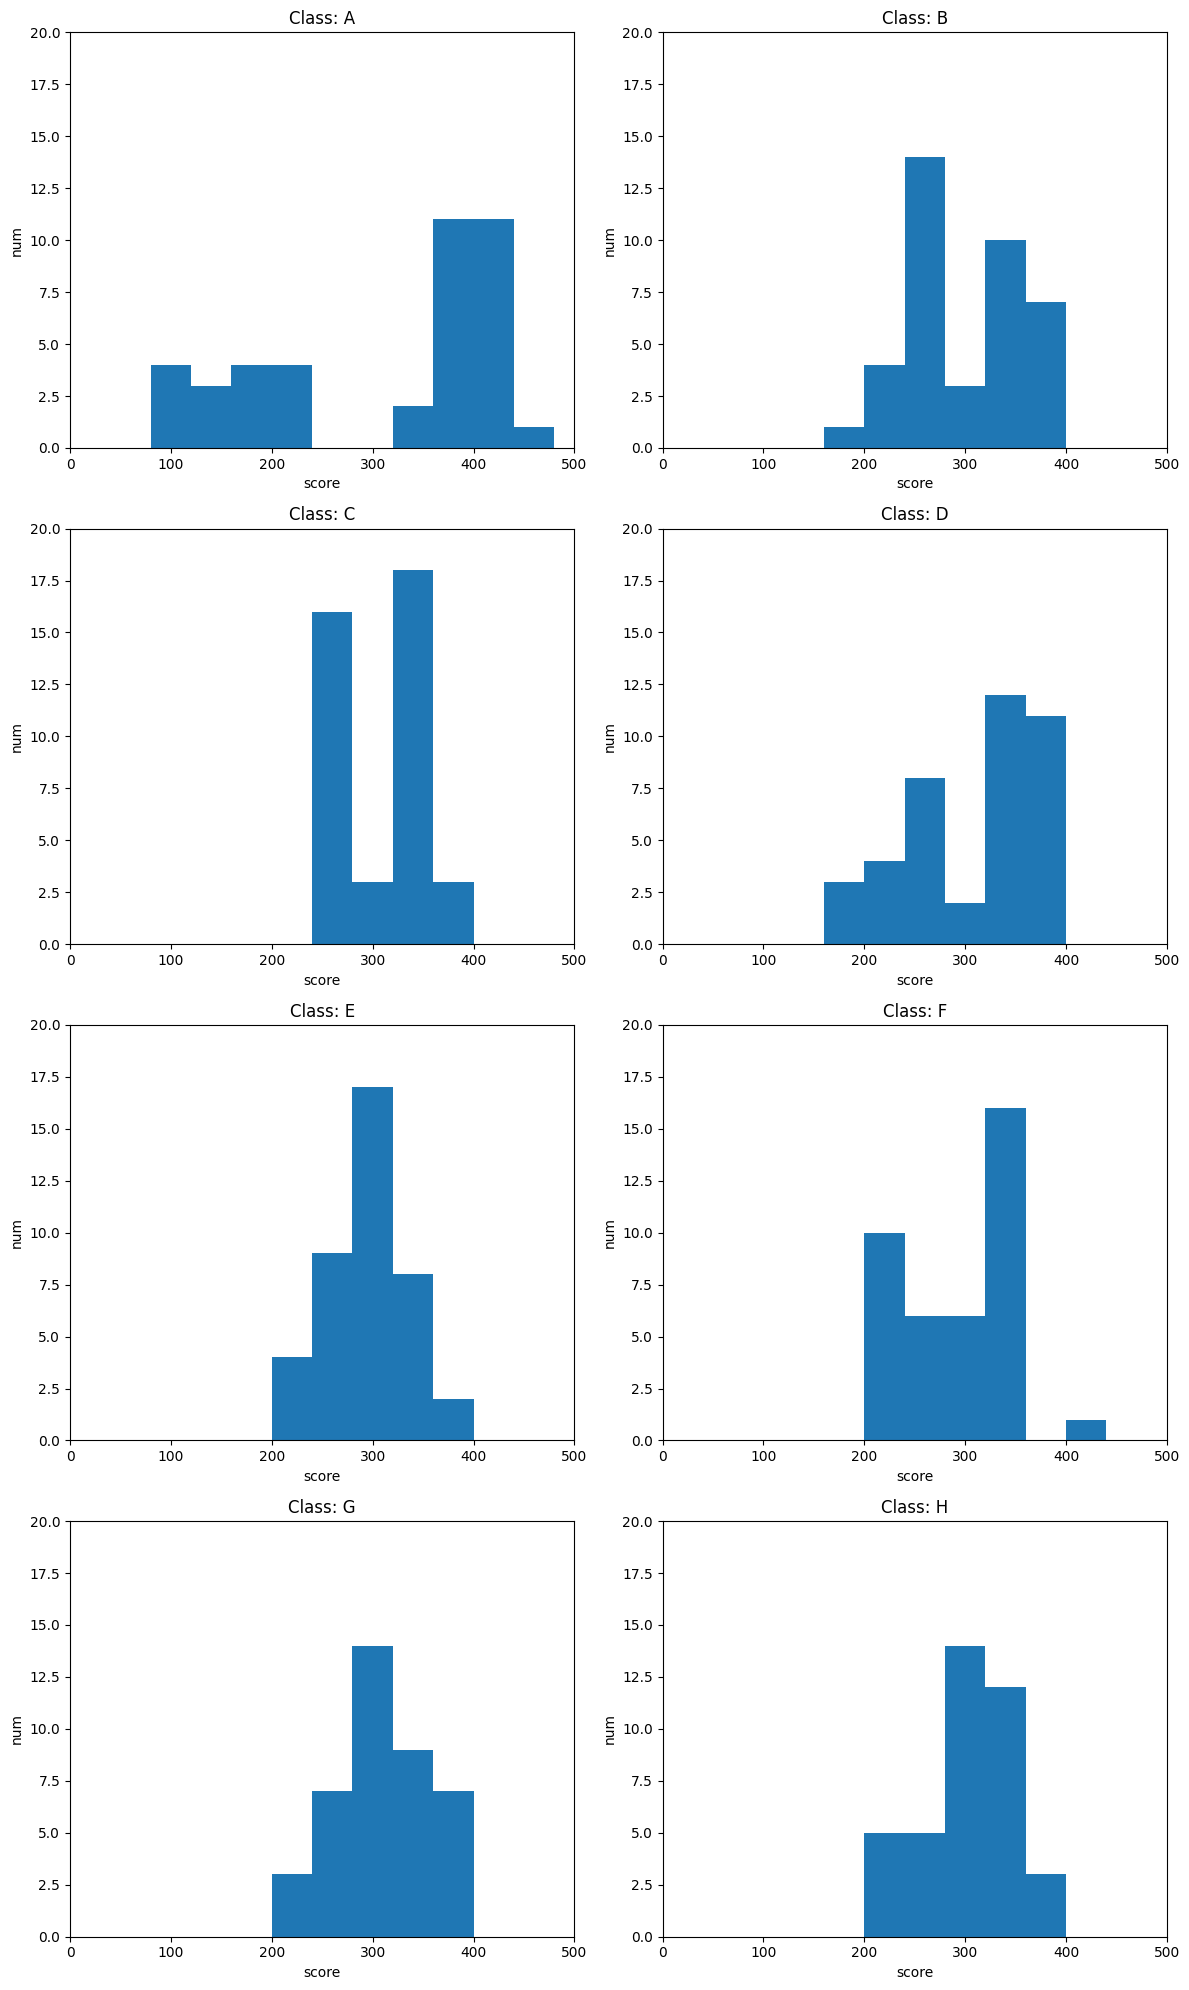

In [ ]:
import matplotlib.pyplot as plt

# 各クラスの点数の分布をヒストグラムで表示する
fig = plt.figure(figsize=(12,20))
for i,c in enumerate(C):                                # i（何番目か）と c（クラス名）が取り出される。
    cls_df = result_df[result_df["assigned_class"]==c]  # 現在のクラスに割り当てられた生徒の全データをcls_dfに追加している。
    
    ax = fig.add_subplot(4, 2, i+1)                     # 4行2列のサブプロットの i+1 番目に描画。
    ax.hist(cls_df["score"], bins=range(0, 500, 40))    # 得点を棒グラフで表示し、０～５００点までを４０点刻みで区切ったヒストグラム。
    
    ax.set_xlabel("score")
    ax.set_ylabel("num")
    ax.set_xlim(0,500)
    ax.set_ylim(0,20)
    ax.set_title(f"Class: {c}")

plt.tight_layout()  # 各クラスが重ならないように自動調整
plt.show()

クラスによって、学力の分布に偏りがある。

クラスの再編成を行う。

実際に学校の先生たちは、以下の作業を行っている。
- 学力順で生徒を各クラスに割り振る
- 要件を満たすまで、クラス間で配置換えを繰り返す。

### つまり、「学力の偏りがない初期編成」を作成しておき、その編成からあまり変化しないように各要件について最適化する。

In [ ]:
# 初期クラス編成のデータを作成
# 学力をもとに順位を付与し、新しいカラム score_rank として追加する。
s_df["score_rank"] = s_df["score"].rank(ascending=False, method="first") 
s_df.head()

,student_id,gender,leader_flag,support_flag,score,score_rank
0,1,0,0,0,335,109.0
1,2,1,0,0,379,38.0
2,3,0,0,0,350,79.0
3,4,0,0,0,301,172.0
4,5,1,0,0,317,147.0


In [ ]:
# 学力順に均等になるように各クラスに割り当て。
class_dic = {0:"A", 1:"B", 2:"C", 3:"D", 4:"E", 5:"F", 6:"G", 7:"H"}

# 以下で、学力の分布のみを考えたクラスの初期編成案を作成
s_df["init_assigned_class"] = s_df["score_rank"].map(lambda x:x % 8).map(class_dic) # score_rankの順位を８で割った余り（０～７）を計算し、それを辞書 class_dic内でクラスに変換。
# 順位を８で割った余りを計算することで、上位から順番に各クラスに振り分けられるので、クラス間の偏りがなくなる。

s_df.head(20)

,student_id,gender,leader_flag,support_flag,score,score_rank,init_assigned_class
0,1,0,0,0,335,109.0,F
1,2,1,0,0,379,38.0,G
2,3,0,0,0,350,79.0,H
3,4,0,0,0,301,172.0,E
4,5,1,0,0,317,147.0,D
5,6,0,0,0,390,21.0,F
6,7,0,0,0,322,134.0,G
7,8,1,0,0,317,148.0,E
8,9,1,0,0,390,22.0,G
9,10,0,0,0,357,62.0,G


次に、初期クラス編成フラグを作成する

In [98]:
# init_falg を作成
init_flag = {(s,c):0 for s in S for c in C}     # 全ての組み合わせに対して０を設定。初期設定。

for row in s_df.itertuples():
    init_flag[row.student_id, row.init_assigned_class] = 1  # その生徒がそのクラスに初期割り当てされていれば、１とする。

最適化計算をする前に、初期クラス編成の中の分布を確認しておく。

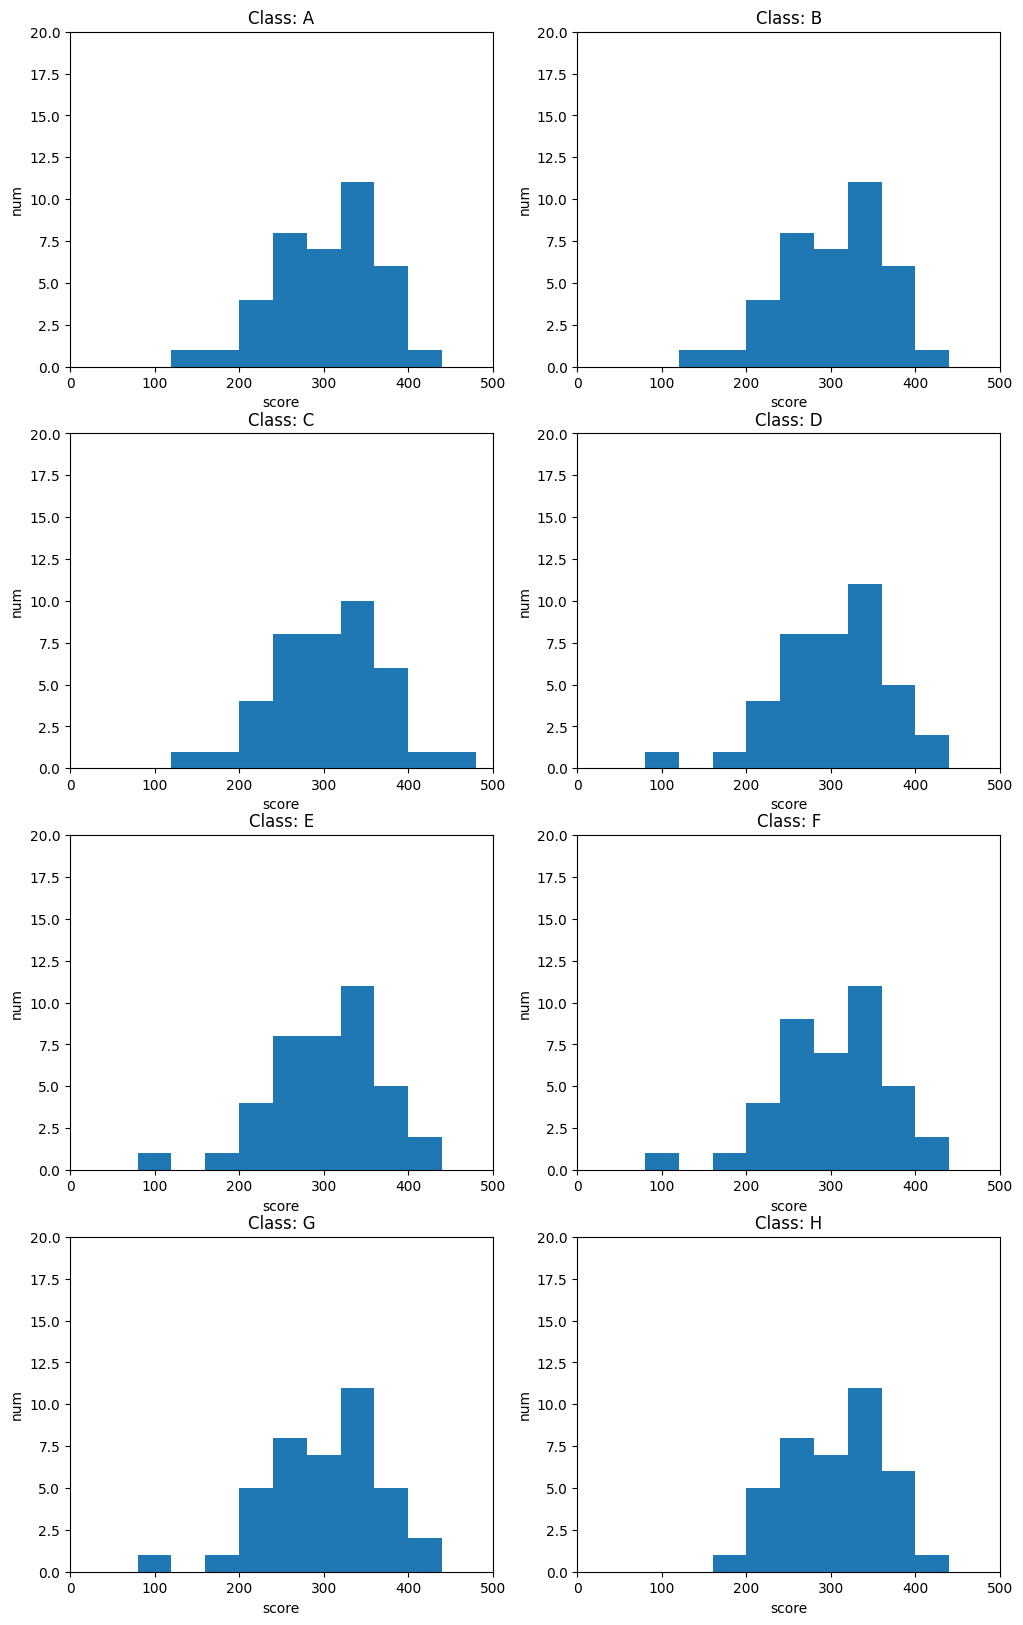

In [99]:
fig = plt.figure(figsize=(12,20))
for i,c in enumerate(C):                                # i（何番目か）と c（クラス名）が取り出される。
    cls_df = s_df[s_df["init_assigned_class"]==c]  # 現在のクラスに割り当てられた生徒の全データをcls_dfに追加している。
    
    ax = fig.add_subplot(4, 2, i+1)                     # 4行2列のサブプロットの i+1 番目に描画。
    ax.hist(cls_df["score"], bins=range(0, 500, 40))    # 得点を棒グラフで表示し、０～５００点までを４０点刻みで区切ったヒストグラム。
    
    ax.set_xlabel("score")
    ax.set_ylabel("num")
    ax.set_xlim(0,500)
    ax.set_ylim(0,20)
    ax.set_title(f"Class: {c}")

これで学力の偏りがなくなったので、新たに目的関数を設定して、要件に合うように最適化する。

In [ ]:
# 目的関数：最適化後も、初期のクラス編成（偏りのない）にできるだけ近い編成にしたい。
prob += pulp.lpSum(x[s,c] * init_flag[s,c] for s,c in SC) # SCは生徒×クラスの全組み合わせ

In [107]:
import pandas as pd
import pulp

s_df = pd.read_csv('students.csv')
s_pair_df = pd.read_csv('student_pairs.csv')

prob = pulp.LpProblem('ClassAssignmentProblem', pulp.LpMaximize)

# 生徒のリスト
S = s_df['student_id'].tolist()

# クラスのリスト
C = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

# 生徒とクラスのペアのリスト
SC = [(s,c) for s in S for c in C]

# 生徒をどのクラスに割り当てるを変数として定義
x = pulp.LpVariable.dicts('x', SC, cat='Binary')

# (1)各生徒は１つのクラスに割り当てる
for s in S:
    prob += pulp.lpSum([x[s,c] for c in C]) == 1

# (2)各クラスの生徒の人数は39人以上、40人以下とする。
for c in C:
    prob += pulp.lpSum([x[s,c] for s in S]) >= 39
    prob += pulp.lpSum([x[s,c] for s in S]) <= 40

# 男子生徒のリスト
S_male = [row.student_id for row in s_df.itertuples() if row.gender == 1]

# 女子生徒のリスト
S_female = [row.student_id for row in s_df.itertuples() if row.gender == 0]

# (3) 各クラスの男子生徒、女子生徒の人数は20人以下とする。
for c in C:
    prob += pulp.lpSum([x[s,c] for s in S_male]) <= 20
    prob += pulp.lpSum([x[s,c] for s in S_female]) <= 20

# 学力を辞書表現に変換
score = {row.student_id:row.score for row in s_df.itertuples()}

# 平均点の算出
score_mean = s_df['score'].mean()

# (4) 各クラスの学力試験の平均点は学年平均点±10点とする。      
for c in C:
    prob += pulp.lpSum([x[s,c]*score[s] for s in S]) >= (score_mean - 10) * pulp.lpSum([x[s,c] for s in S])
    prob += pulp.lpSum([x[s,c]*score[s] for s in S]) <= (score_mean + 10) * pulp.lpSum([x[s,c] for s in S])

# リーダー気質の生徒の集合
S_leader = [row.student_id for row in s_df.itertuples() if row.leader_flag == 1]

# (5)各クラスにリーダー気質の生徒を2人以上割り当てる。
for c in C:
    prob += pulp.lpSum([x[s,c] for s in S_leader]) >= 2

# 特別な支援が必要な生徒の集合
S_support = [row.student_id for row in s_df.itertuples() if row.support_flag == 1]
# (6) 特別な支援が必要な生徒は各クラスに1人以下とする。
for c in C:
    prob += pulp.lpSum([x[s,c] for s in S_support]) <= 1

# 生徒の特定ペアリスト
SS = [(row.student_id1, row.student_id2) for row in s_pair_df.itertuples()]
# (7) 特定ペアの生徒は同一クラスに割り当てない。
for s1, s2 in SS:
    for c in C:
        prob += x[s1,c] + x[s2,c] <= 1

# 初期クラス編成を作成
s_df['score_rank'] = s_df['score'].rank(ascending=False, method='first')
class_dic = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6:'G', 7:'H'}
s_df['init_assigned_class'] = s_df['score_rank'].map(lambda x:x % 8).map(class_dic)
init_flag = {(s,c): 0 for s in S for c in C}
for row in s_df.itertuples():
    init_flag[row.student_id, row.init_assigned_class] = 1
    
# 目的関数:初期クラス編成と最適化結果のクラス編成をできるだけ一致させる
prob += pulp.lpSum([x[s,c] * init_flag[s,c] for s,c in SC])        

# 求解        
status = prob.solve()
print('Status:', pulp.LpStatus[status])

# 最適化結果の表示
# 各クラスに割り当てられている生徒のリストを辞書に格納
C2Ss = {}
for c in C:
    C2Ss[c] = [s for s in S if x[s,c].value()==1]
    
for c, Ss in C2Ss.items():
    print('Class:', c)
    print('Num:', len(Ss))
    print('Student:', Ss)
    print()

Status: Optimal
Class: A
Num: 40
Student: [2, 23, 56, 68, 76, 82, 89, 102, 106, 113, 115, 121, 123, 124, 127, 140, 172, 173, 185, 186, 204, 210, 228, 255, 267, 273, 274, 280, 285, 288, 289, 292, 295, 297, 304, 308, 311, 313, 316, 318]

Class: B
Num: 39
Student: [11, 14, 17, 30, 32, 35, 41, 49, 64, 66, 79, 83, 86, 88, 97, 114, 119, 122, 132, 134, 141, 149, 151, 165, 175, 178, 190, 198, 200, 209, 213, 216, 226, 237, 272, 296, 303, 306, 307]

Class: C
Num: 40
Student: [21, 38, 44, 46, 51, 54, 62, 63, 73, 75, 84, 85, 99, 120, 138, 142, 143, 144, 150, 166, 183, 184, 192, 193, 195, 201, 205, 207, 211, 212, 217, 221, 222, 243, 244, 263, 264, 287, 299, 315]

Class: D
Num: 40
Student: [5, 24, 39, 47, 50, 61, 67, 74, 90, 92, 93, 100, 109, 116, 131, 136, 147, 152, 155, 167, 169, 170, 176, 177, 196, 199, 214, 218, 219, 227, 230, 231, 236, 238, 239, 253, 257, 259, 271, 309]

Class: E
Num: 39
Student: [4, 8, 12, 13, 19, 22, 33, 43, 48, 55, 57, 59, 98, 112, 125, 130, 133, 137, 139, 153, 160, 189, 203

再度、検証するためのデータフレームresult_df2 を作成。

In [108]:
# 検証用データフレームの準備
result_df2 = s_df.copy()

# 各生徒がどのクラスに割り当てられたかの情報を辞書に格納
S2C = {}
for s in S:
    S2C[s] = [c for c in C if x[s,c].value() == 1][0]  # [0]があることによって、要素１個のリストの中身を値として抽出できる。

print(S2C)

# 生徒データに、どのクラスに割り当てられたかの情報を追加。
result_df2["assigned_class"] = result_df2["student_id"].map(S2C)  # student_id の値を辞書の対応値に変換
result_df2.head(10)

{1: 'F', 2: 'A', 3: 'H', 4: 'E', 5: 'D', 6: 'F', 7: 'G', 8: 'E', 9: 'G', 10: 'G', 11: 'B', 12: 'E', 13: 'E', 14: 'B', 15: 'G', 16: 'F', 17: 'B', 18: 'G', 19: 'E', 20: 'H', 21: 'C', 22: 'E', 23: 'A', 24: 'D', 25: 'H', 26: 'G', 27: 'F', 28: 'F', 29: 'F', 30: 'B', 31: 'G', 32: 'B', 33: 'E', 34: 'H', 35: 'B', 36: 'G', 37: 'G', 38: 'C', 39: 'D', 40: 'F', 41: 'B', 42: 'F', 43: 'E', 44: 'C', 45: 'F', 46: 'C', 47: 'D', 48: 'E', 49: 'B', 50: 'D', 51: 'C', 52: 'G', 53: 'H', 54: 'C', 55: 'E', 56: 'A', 57: 'E', 58: 'F', 59: 'E', 60: 'H', 61: 'D', 62: 'C', 63: 'C', 64: 'B', 65: 'H', 66: 'B', 67: 'D', 68: 'A', 69: 'H', 70: 'F', 71: 'G', 72: 'H', 73: 'C', 74: 'D', 75: 'C', 76: 'A', 77: 'F', 78: 'G', 79: 'B', 80: 'G', 81: 'H', 82: 'A', 83: 'B', 84: 'C', 85: 'C', 86: 'B', 87: 'H', 88: 'B', 89: 'A', 90: 'D', 91: 'F', 92: 'D', 93: 'D', 94: 'G', 95: 'H', 96: 'G', 97: 'B', 98: 'E', 99: 'C', 100: 'D', 101: 'G', 102: 'A', 103: 'H', 104: 'G', 105: 'H', 106: 'A', 107: 'H', 108: 'H', 109: 'D', 110: 'G', 111: 'H

,student_id,gender,leader_flag,support_flag,score,score_rank,init_assigned_class,assigned_class
0,1,0,0,0,335,109.0,F,F
1,2,1,0,0,379,38.0,G,A
2,3,0,0,0,350,79.0,H,H
3,4,0,0,0,301,172.0,E,E
4,5,1,0,0,317,147.0,D,D
5,6,0,0,0,390,21.0,F,F
6,7,0,0,0,322,134.0,G,G
7,8,1,0,0,317,148.0,E,E
8,9,1,0,0,390,22.0,G,G
9,10,0,0,0,357,62.0,G,G


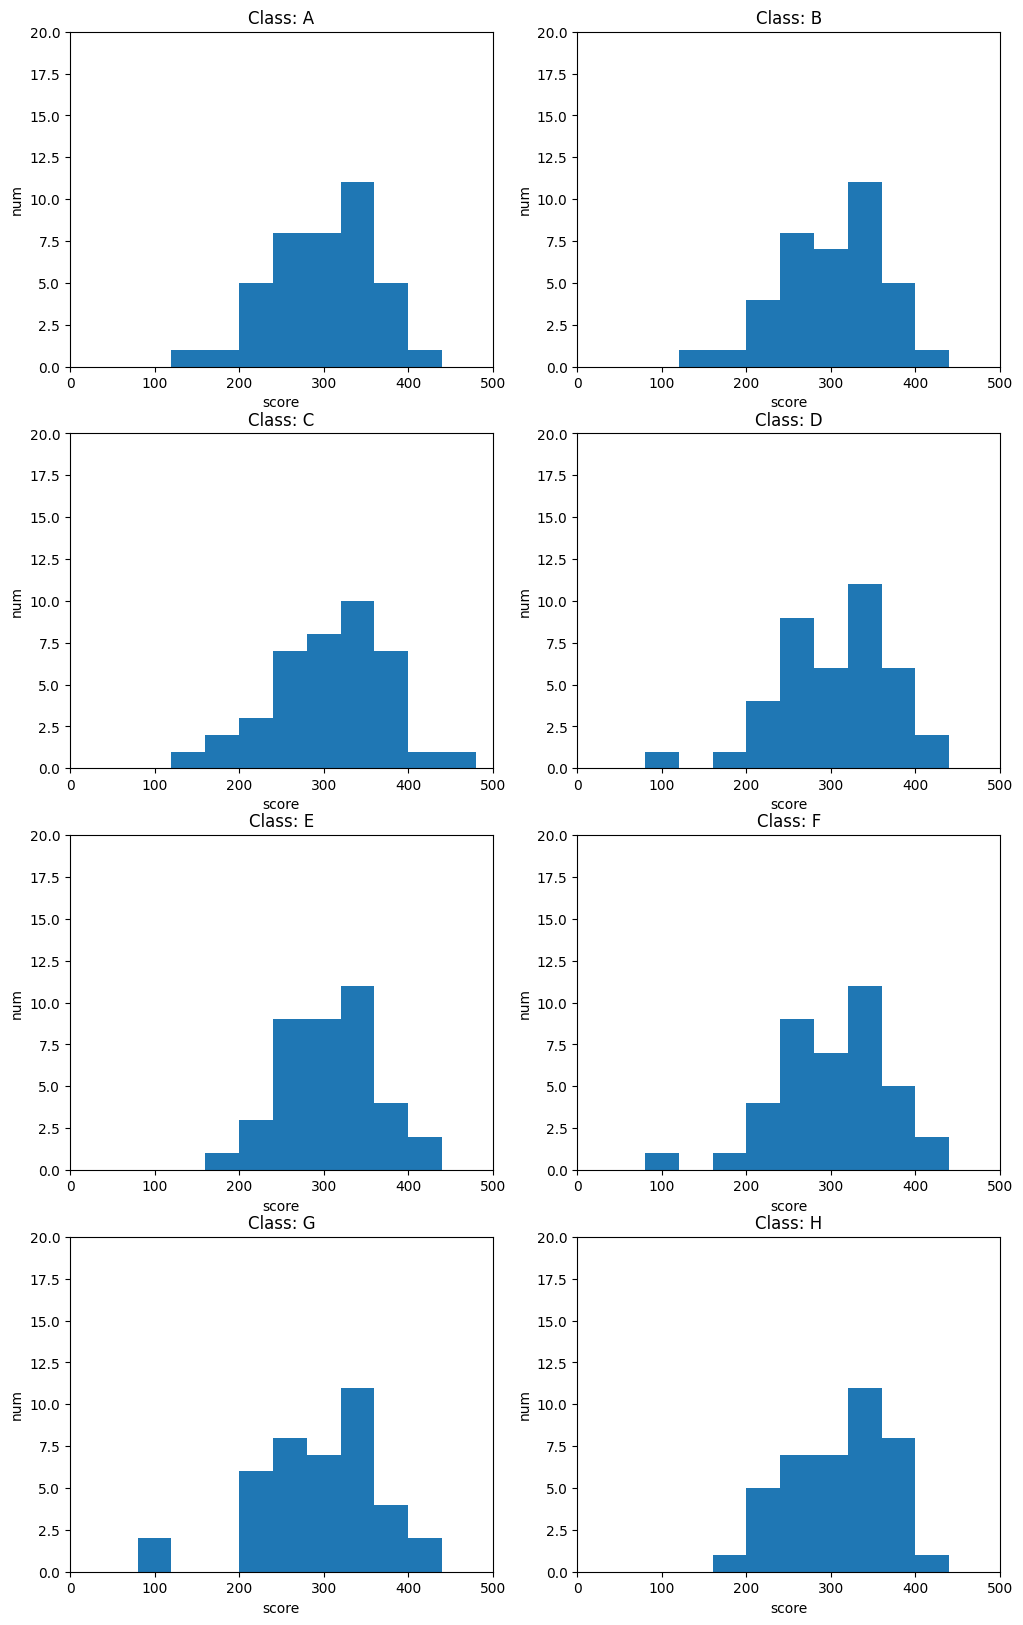

In [109]:
fig = plt.figure(figsize=(12,20))
for i,c in enumerate(C):                                # i（何番目か）と c（クラス名）が取り出される。
    cls_df = result_df2[result_df2["assigned_class"]==c]  # 現在のクラスに割り当てられた生徒の全データをcls_dfに追加している。
    
    ax = fig.add_subplot(4, 2, i+1)                     # 4行2列のサブプロットの i+1 番目に描画。
    ax.hist(cls_df["score"], bins=range(0, 500, 40))    # 得点を棒グラフで表示し、０～５００点までを４０点刻みで区切ったヒストグラム。
    
    ax.set_xlabel("score")
    ax.set_ylabel("num")
    ax.set_xlim(0,500)
    ax.set_ylim(0,20)
    ax.set_title(f"Class: {c}")